In [2]:
from google.colab import drive
import os
import numpy as np
from PIL import Image

gdrive_path='/content/gdrive/MyDrive/Deep_Learning/Semantic_dataset'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are presentd
# print(sorted(os.listdir()))
# np.array(Image.open(os.listdir('train_masks')[0].replace(".jpg", "_mask.gif")))


Mounted at /content/gdrive


In [3]:
os.listdir()

['U-net.jpg', 'train', 'masks', 'test_masks', 'test_images']

In [4]:
images_path = os.path.join(gdrive_path, "train")
masks_path = os.path.join(gdrive_path, "masks")
test_images_path = os.path.join(gdrive_path, "test_images")
test_masks_path = os.path.join(gdrive_path, "test_masks")

In [5]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import functional as f
from torch import optim
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt

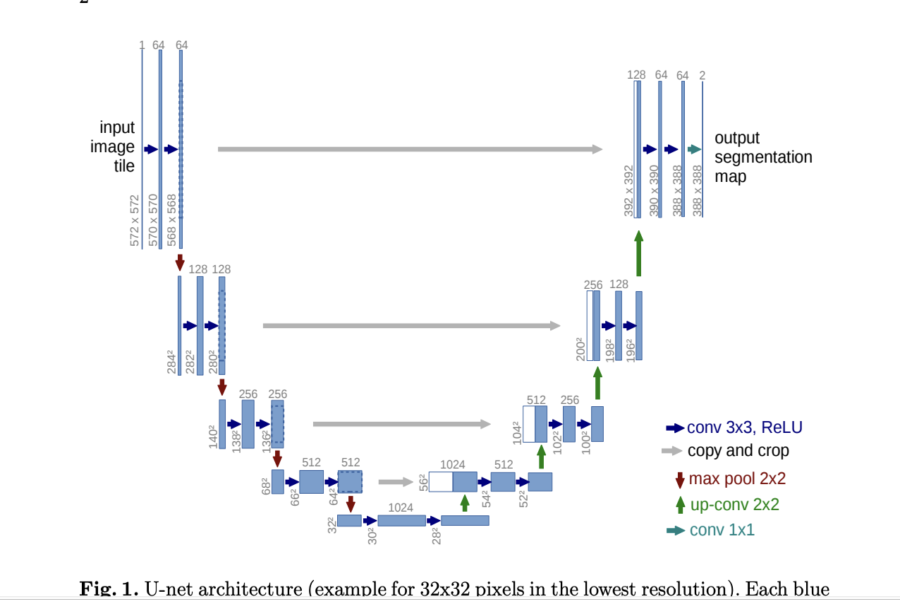

In [6]:
im = Image.open("U-net.jpg")
f.resize(im, (600,900))

## As we can see in the above picture in the architecture double convolution has been used so to apply double convolution we will make a class of double convolution.



1.   Convolution
2.   Batchnorm
3.   Relu



#### Here we create a class called conv_block where all the convolution, batchnormalization and activation functions will be mentioned.

In [7]:
class conv_block(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(conv_block, self).__init__() # inheriting the superior class
# as we can see in the image that we are using 2 layers of convolutions hence we will code accordingly.
# in the constructor we have defined all the layers.
    self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size= 3, padding = 1 )
    self.bn1 = nn.BatchNorm2d(output_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3, padding =1)
    self.bn2 = nn.BatchNorm2d(output_channel)

  def forward(self, x):
    output_1 = self.conv1(x)
    output_2 = self.bn1(output_1)
    output_3 = self.relu(output_2)
    output_4 = self.conv2(output_3)
    output_5 = self.bn2(output_4)
    output_6 = self.relu(output_5)
    return output_6


### Now here we will here build the pooling layers those we used in the encoding process.

In [8]:
class encoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super(encoder_block, self).__init__()
    self.conv = conv_block(in_c, out_c)
    self.pooling = nn.MaxPool2d((2,2))

  def forward(self, x):
    output_1 = self.conv(x)
    output_2 = self.pooling(output_1)
    return output_1, output_2 # here output_1 behaves as a skip connection as we can see in the image.



#### Now we will formulate the decoder block and we are difining a layer hence we will be inheriting from the nn.Module class.Here as shown in the paper that each upsampling is followed by a kernel size =2 and padding will also be equal to kernel size.

In [9]:
class decoder_block(nn.Module):
  # in constructor block we have defined the layers of NN.
  def __init__(self, input_chanels, output_chanels):
    super(decoder_block, self). __init__()
    self.up = nn.ConvTranspose2d(input_chanels, output_chanels, kernel_size = 2, stride = 2, padding =0 )
    self.conv = conv_block(output_chanels+output_chanels, output_chanels)

  def forward(self, input, skip ):
    output1 = self.up(input)
    output2 = torch.cat([output1,skip], axis =1)
    output3 = self.conv(output2)
    return output3

## Now as we can see that the main operations coding functions we have already made now we can assemble everything to make the network.

In [10]:
class build_unet(nn.Module):
  def __init__(self):
    super(build_unet, self).__init__()

    """  Encoder   """
    self.e1 = encoder_block(3, 64)
    self.e2 = encoder_block(64, 128)
    self.e3 = encoder_block(128, 256)
    self.e4 = encoder_block(256, 512)

    """ Bottleneck """
    self.b = conv_block(512, 1024)

    """ in decoder block we need an input coming from bottle-neck hence we will be implementing two convolutions here """
    self.d1 = decoder_block(1024, 512)
    self.d2 = decoder_block(512, 256)
    self.d3 = decoder_block(256, 128)
    self.d4 = decoder_block(128, 64)
    self.d5 = nn.Conv2d(64, 1,  1, stride =1 ,padding = 0)

  def forward(self, x):
    conv1, pool1 = self.e1(x)
    conv2, pool2 = self.e2(pool1)
    conv3, pool3 = self.e3(pool2)
    conv4, pool4 = self.e4(pool3)
    output5 = self.b(pool4)
    output6 = self.d1(output5, conv4)
    output7 = self.d2(output6, conv3)
    output8 = self.d3(output7, conv2)
    output9 = self.d4(output8, conv1)
    output10 = self.d5(output9)
    return output10


In [11]:
model = build_unet()

In [12]:
input = torch.randn((2, 3, 160, 240))

In [13]:
output = model(input)
output.shape


torch.Size([2, 1, 160, 240])

#### Defining the transforms

In [14]:
# train_transform = A.Compose([A.Resize(height =160, width = 160),
#                              A.Rotate(limit = 35, p=1.0),
#                              A.HorozontalFlip(p=0.5),
#                              A.VerticalFlip(p=0.1),
#                              A.Normalize(mean = [0.0,0.0,0.0],std =[1.0,1.0,1.0],max_pixel_value = 255.0),



#                              ])

# train_transform = transforms.Compose([]) # we need to have all the images one size so that our model can be trained effeciently.# in the molde PIL Image can not be fed so we need to convert it in to the trnsor

# test_transform = transforms.Compose([transforms.Resize((256, 256))])
train_transform = transforms.Resize((160,240))
test_transform = transforms.Resize((160, 240))


## Now we will build a dataset for training the model. Importing the dataset and dataloader.

In [15]:
class CarvanaDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)


  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir, self.masks[index].replace("mask_gif",".jpg"))
    image = np.array(Image.open(image_path).convert("RGB"))
    image = transforms.ToTensor()(image)
    mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32)
    mask[mask ==255.0] = 1.0
    mask = transforms.ToTensor()(mask)
    if self.transform is not None:
      image = self.transform(image)
      mask = self.transform(mask)

    return image, mask




#### Checking the dataset part.

In [16]:
image_dir = images_path
mask_dir = masks_path
test_image = test_images_path
test_masks = test_masks_path

In [17]:
os.path.join(image_dir, os.listdir(image_dir)[0])



'/content/gdrive/MyDrive/Deep_Learning/Semantic_dataset/train/cf65b1c5e147_16.jpg'

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


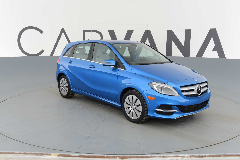

In [18]:
test_dataset = CarvanaDataset(image_dir, mask_dir, train_transform).__getitem__(3)
transforms.ToPILImage()(test_dataset[0])

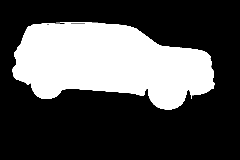

In [19]:
transforms.ToPILImage()(test_dataset[1])

In [20]:
train_dl = DataLoader(CarvanaDataset(image_dir, mask_dir, train_transform), batch_size = 60, shuffle = False, num_workers =2)

In [ ]:
for data, target in train_dl:
  print(data.shape, target.shape)
  break

torch.Size([60, 3, 160, 240]) torch.Size([60, 1, 160, 240])


In [21]:
test_dl = DataLoader((CarvanaDataset(test_image, test_masks, test_transform)), batch_size = 60, shuffle = False, num_workers =2)



Now we are training our network.

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [23]:

num_epochs = 10
training_loss =[]
test_loss = []


for epoch in range(num_epochs):
  train_epoch_loss = 0
  test_epoch_loss = 0
  for data, target in train_dl:
    output = model(data)
    loss = loss_fn(output, target)
    train_epoch_loss += loss.detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    for data, target in test_dl:
      output = model(data)
      loss = loss_fn(output, target)
      test_epoch_loss += loss.detach().numpy()
      optimizer.zero_grad()



  training_loss.append(train_epoch_loss)
  test_loss.append(test_epoch_loss)


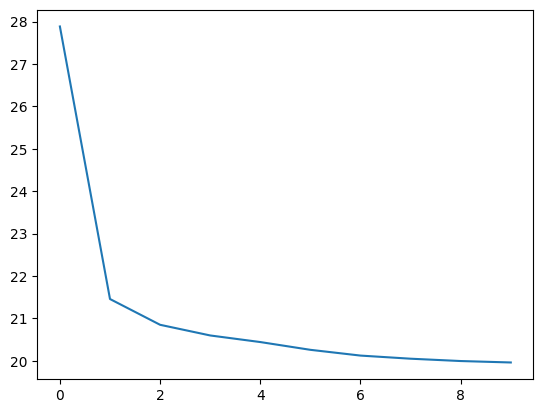

In [24]:
plt.plot(training_loss)

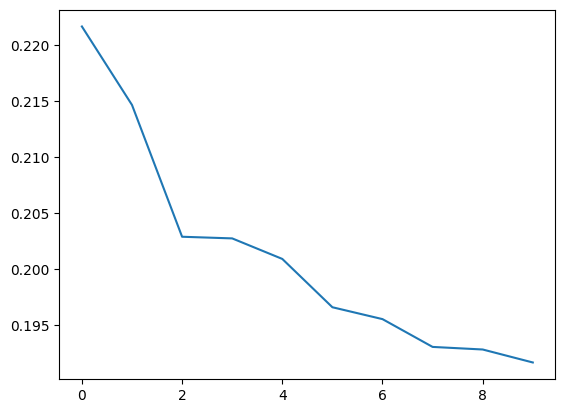

In [25]:
plt.plot(test_loss)

In [26]:
for data, target in train_dl:
  predi = model(data[0:4])
  actual = target[0:4]
  break



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [27]:
predictions[0].size()

torch.Size([1, 160, 240])

In [1]:
# transforms.ToPILImage()(predictions[1])

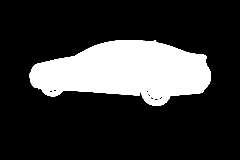

In [29]:
transforms.ToPILImage()(actual[0])


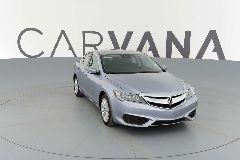

In [30]:
transforms.ToPILImage()(data[0])